In [2]:
# All useful libraries
import os
import librosa
import numpy as np
import sklearn
import pandas as pd

from models.linear_regression import LinearRegression
from sklearn.model_selection import train_test_split

from utils import download_dataset_if_needed, get_dataset
from feature_extraction.rms import generate_rms, normalize_rms, reshape_rms

from datasets import livingroom

## Load the dataset

We need to load the dataset from Human1. Deconvoled file represents that we only have the audio signal we need to work on, no background noise only the first clap and the reverb.

In [3]:
download_dataset_if_needed()

path: ./LivingRoom_preprocessed_hack already exist, ignorign dataset downloading


In [4]:
DATASET_PATH = "LivingRoom_preprocessed_hack"
empty_dataset = get_dataset(None, "deconvolved.npy", os.path.join(DATASET_PATH, "Empty"))
human1_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human1"))

Shape of RIRs:
(100, 10, 667200)
Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)


Compute the RMS of the first value of the first channel (mic) as exemple :

In [5]:
human_rms = generate_rms(human1_dataset)

Load precomputed rms


We now have all the RMS value for each microphone:

The Y are the position of the Human that we have in the centroid array:

In [5]:
y_all = human1_dataset[1].copy()
y_all

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

We do not want to scale the position with each other we want to scale them to the size of the room that are provided in the research paper, we define the following functions:

In [6]:
def min_max_scale(x, min, max):
    return (x - min) / (max - min)


def min_max_unscale(x, min, max):
    return x * (max - min) + min

In [7]:
def rescale(y):
    y[:, 0] = min_max_scale(y[:,0], livingroom.x_min, livingroom.x_max)
    y[:, 1] = min_max_scale(y[:,1], livingroom.y_min, livingroom.y_max)
    return y

def unscale(y):
    y[:,0] = min_max_unscale(y[:,0], livingroom.x_min, livingroom.x_max)
    y[:,1] = min_max_unscale(y[:,1], livingroom.y_min, livingroom.y_max)
    return y

In [8]:
y_all = rescale(y_all)

We normalize the channels data that are mostly 10e-5 because if we keep them like that we lose precision since the model works between 0 and 1:

In [9]:
X_all = sklearn.preprocessing.normalize(human_rms, axis=0)
X_all

array([[0.03269232, 0.03207606, 0.03206741, 0.03218653],
       [0.03242992, 0.03190551, 0.03201022, 0.0321255 ],
       [0.032501  , 0.03185849, 0.03193082, 0.03213471],
       ...,
       [0.03225974, 0.03162933, 0.03117786, 0.03154419],
       [0.03211814, 0.03133547, 0.03117299, 0.03141627],
       [0.03211524, 0.03177294, 0.01858061, 0.02678968]], dtype=float32)

Split the dataset 80% training and 20% testing:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True)

In [11]:
X_train.shape

(800, 4)

In [12]:
y_train.shape

(800, 2)

Define the model:

In [13]:
model = LinearRegression()

In [14]:
model.fit(X_train,y_train)

In [15]:
y_pred = model.predict(X_test)

In [16]:
print(y_pred)

[[0.4792558  0.52829695]
 [0.40123856 0.5479622 ]
 [0.47576797 0.47861648]
 [0.42662668 0.51284885]
 [0.36472464 0.3651471 ]
 [0.4136194  0.553365  ]
 [0.47605455 0.5671885 ]
 [0.30874705 0.43427658]
 [0.45143974 0.48939776]
 [0.4411292  0.51619077]
 [0.40576935 0.35302734]
 [0.40037405 0.47744966]
 [0.40012312 0.5725534 ]
 [0.38208938 0.40640354]
 [0.39206386 0.4290192 ]
 [0.3756441  0.506953  ]
 [0.44753468 0.5772829 ]
 [0.41601276 0.4194324 ]
 [0.4289844  0.46735454]
 [0.48723245 0.5470052 ]
 [0.51420224 0.4682238 ]
 [0.4915222  0.4828248 ]
 [0.4547131  0.4789076 ]
 [0.44134808 0.53493834]
 [0.46030617 0.51805854]
 [0.46515918 0.60377955]
 [0.48238218 0.46898174]
 [0.3829776  0.6050329 ]
 [0.4585681  0.54006433]
 [0.38994193 0.6022713 ]
 [0.47119784 0.4934833 ]
 [0.4411435  0.55843425]
 [0.43111765 0.57484007]
 [0.42130125 0.49163198]
 [0.6348324  0.40507078]
 [0.43948007 0.5286181 ]
 [0.41137064 0.33707857]
 [0.42746675 0.47159028]
 [0.43497276 0.5235481 ]
 [0.38811684 0.59468627]


We have to convert back the position:

In [17]:
y_test = unscale(y_test)
y_pred = unscale(y_pred)
print(y_pred)

[[-1843.3489   -830.21826]
 [-2194.4265   -712.2268 ]
 [-1859.0442  -1128.301  ]
 [-2080.18     -922.907  ]
 [-2358.7393  -1809.1174 ]
 [-2138.7126   -679.81006]
 [-1857.7546   -596.8689 ]
 [-2610.6382  -1394.3406 ]
 [-1968.5211  -1063.6135 ]
 [-2014.9186   -902.85547]
 [-2174.038   -1881.8359 ]
 [-2198.317   -1135.302  ]
 [-2199.4458   -564.6797 ]
 [-2280.5977  -1561.5789 ]
 [-2235.7126  -1425.8848 ]
 [-2309.6016   -958.282  ]
 [-1986.094    -536.3025 ]
 [-2127.9424  -1483.4055 ]
 [-2069.5703  -1195.8728 ]
 [-1807.4541   -717.969  ]
 [-1686.0898  -1190.6572 ]
 [-1788.1501  -1103.0513 ]
 [-1953.791   -1126.5544 ]
 [-2013.9337   -790.3699 ]
 [-1928.6223   -891.6487 ]
 [-1906.7837   -377.32275]
 [-1829.2803  -1186.1096 ]
 [-2276.6008   -369.8025 ]
 [-1936.4436   -759.614  ]
 [-2245.2612   -386.37207]
 [-1879.6096  -1039.1001 ]
 [-2014.8542   -649.39453]
 [-2059.9707   -550.9595 ]
 [-2104.1445  -1050.208  ]
 [-1143.2544  -1569.5752 ]
 [-2022.3397   -828.2915 ]
 [-2148.832   -1977.5286 ]
 

Compute the Euclidean distance of each position:

In [18]:
dist = np.linalg.norm(y_pred - y_test,axis=1)

Get the average to compute the error:

In [19]:
avg = np.average(dist)
std = np.std(dist)
print("Distance difference from real position in centimeters:", avg / 10)
print("Standard deviation in centimeters:", std / 10)

Distance difference from real position in centimeters: 145.5276061300125
Standard deviation in centimeters: 59.601145938204


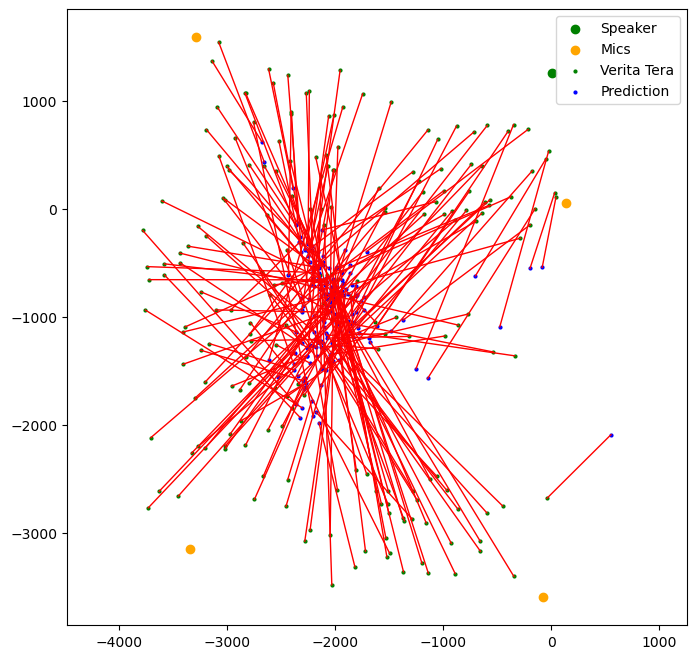

In [20]:
human1_dataset[0].room_setup.plot_prediction(y_pred, y_test)

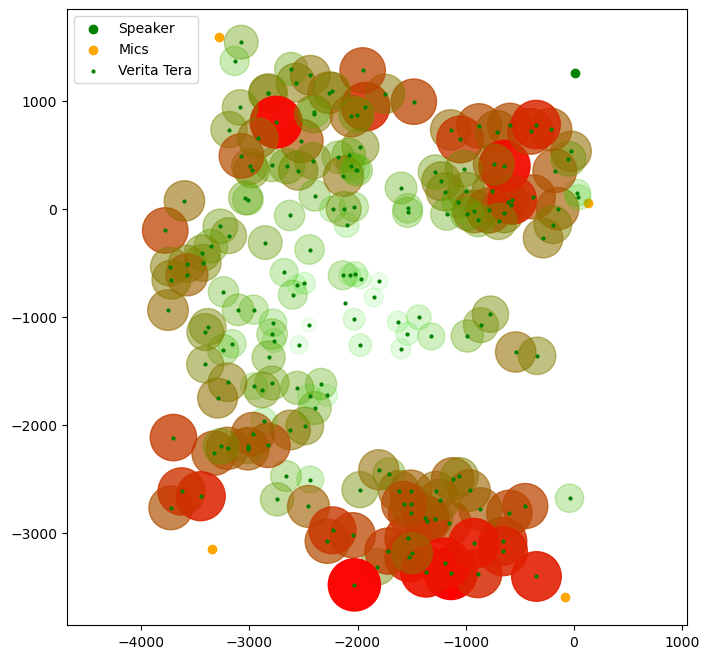

In [21]:
human1_dataset[0].room_setup.plot_heatmap(y_pred, y_test, avg)